In [464]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from tqdm import tqdm

In [13]:
# Настройка рабочего стола и вывода инфы в пандас
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 15
pd.options.display.precision = 7
pd.options.display.max_colwidth = 50

## Data Upload

In [450]:
# Загружаем данные по скважинам, переименовываем, окгуляем, сортируем
sug_gr_init = pd.read_csv('sug_gr_zones_clean.csv', encoding = 'utf8', sep = ',')
sug_gr_init = sug_gr_init.iloc[:, 1:]
sug_gr_init = sug_gr_init.drop('datasetName', axis=1)
sug_gr_init.rename(columns={'wellName':'well',
                      'DEPT':'md',
                      'GR':'gr',
                      'SP':'sp',
                      'TVDBML':'tvdss',
                      'X':'x',
                      'Y':'y',
                      'ZONES':'zones'}, inplace=True)
sug_gr_init = sug_gr_init.round({'tvdss':1, 'gr':1, 'sp':0})
sug_gr_init[['a','b']] = sug_gr_init.well.str.split('-', expand=True)
sug_gr_init = sug_gr_init.drop(['well','a'], axis=1)
sug_gr_init.rename(columns={'b':'well'}, inplace=True)
sug_gr_init = sug_gr_init[['well','tvdss', 'md', 'gr', 'sp', 'x', 'y', 'zones']]

In [451]:
# Проверка как все выглядит
sug_gr_init

,well,tvdss,md,gr,sp,x,y,zones
0,117R,2540.7,2643.2,8.3,127.0,441070.5,7102367.6,БС5-БС6_TOP_S
1,117R,2540.8,2643.3,8.2,121.0,441070.5,7102367.6,БС5-БС6_TOP_S
2,117R,2540.9,2643.4,8.1,115.0,441070.5,7102367.6,БС5-БС6_TOP_S
3,117R,2541.0,2643.5,8.2,111.0,441070.5,7102367.6,БС5-БС6_TOP_S
4,117R,2541.1,2643.6,8.2,107.0,441070.5,7102367.6,БС5-БС6_TOP_S
...,...,...,...,...,...,...,...,...
302061,801R,2862.5,2982.7,8.7,148.0,418809.0,7033340.0,БС10-2-2_TOP_S
302062,801R,2862.6,2982.8,8.5,147.0,418809.0,7033340.0,БС10-2-2_TOP_S
302063,801R,2862.7,2982.9,8.3,147.0,418809.0,7033340.0,БС10-2-2_TOP_S
302064,801R,2862.8,2983.0,8.2,147.0,418809.0,7033340.0,БС10-2-2_TOP_S


In [504]:
# sug_gr_init[sug_gr_init.well=='402R'] #Визуализация таблицы по скважине, на всякий случай

In [506]:
print('Количество скважин изначально:', len(sug_gr_init.well.unique()))

Количество скважин изначально: 71


In [455]:
# Банлист скважин, которые слишком близко друг к другу
well_blaclklist = ['407RG','410RG', '1PG', '433R', '407RST2', '402R', '1P', '476RG']
sug_gr  = sug_gr_init[~sug_gr_init.well.isin(well_blaclklist)]

In [456]:
# Уайтлист зон, с которые будем работать
zones_whitelist = ['БС5-БС6_TOP_S', 'БС6-1_TOP_S', 'БС7_TOP_S', 'БС8-0_TOP_S',
       'БС8-0-1_TOP_S', 'БС9-0_TOP_S', 'БС9_TOP_S', 'БС9-1_TOP_S',
       'БС9-2-1+2_TOP_S', 'БС9-2-3_TOP_S']
sug_gr  = sug_gr[sug_gr.zones.isin(zones_whitelist)]

In [509]:
print('Количество скважин после чистки:', len(sug_gr.well.unique()))

Количество скважин после чистки: 62


In [507]:
# Берем координаты самой верхней и самой нижней зон в каждой скважине
sug_gr_xy_top = sug_gr.groupby('well')[['x','y', 'zones']].apply(lambda x: x.iloc[0])
sug_gr_xy_bot = sug_gr.groupby('well')[['x','y', 'zones']].apply(lambda x: x.iloc[-1])
sug_gr_xy_bot = sug_gr_xy_bot.query('x > 0')
# sug_gr_xy_top

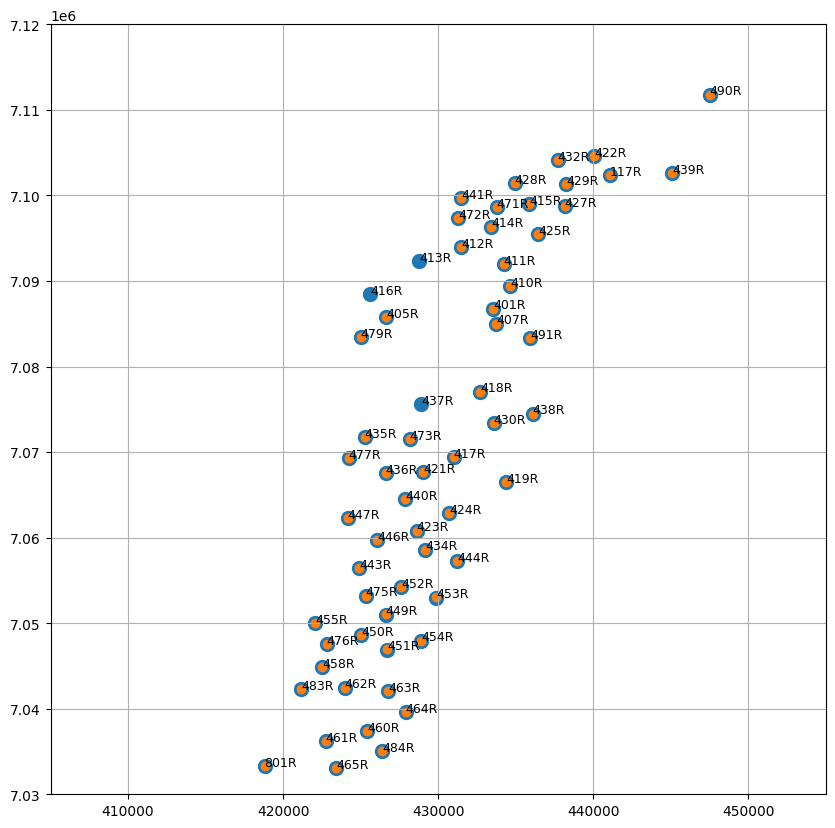

In [459]:
# Визуализируем распределение скважин на схеме
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(sug_gr_xy_top.x, sug_gr_xy_top.y, s=100)
ax.scatter(sug_gr_xy_bot.x, sug_gr_xy_bot.y)
# ax.set_ylim(7_030_000, 7_120_000)
ax.set_ylim(7_030_000, 7_120_000)
# ax.set_xlim(405_000, 455_000)
ax.set_xlim(405_000, 455_000)
for num, names in enumerate(sug_gr_xy_top.index):
    ax.annotate(names, xy = (sug_gr_xy_top.x[num], sug_gr_xy_top.y[num]), fontsize=9)
ax.grid()

In [503]:
window=10 #окно в 0.1м для осреднения ГК
for well_name in tqdm(well_list):
# for well_name in well_list[:5]: # включить если понадобится отобразить немного графиков в блокноте
    f, ax_gr = plt.subplots(figsize=(3,12))
    plt.gca().invert_yaxis()
    well_diplay = sug_gr[(sug_gr.well== well_name) & (sug_gr.gr >0) & (sug_gr.sp >0) & (sug_gr.tvdss >0)]
    well_diplay['gr_avg'] = well_diplay['gr'].rolling(window).mean() #скользящее среднее в 1м
    text_pos = min(well_diplay.gr)+1
    ax_gr.plot(well_diplay.gr, well_diplay.tvdss, c='green', alpha=0.5)
    ax_gr.plot(well_diplay.gr_avg, well_diplay.tvdss, c='green')
    ax_gr.tick_params(axis='x', labelcolor='green')
    ax_sp = ax_gr.twiny() 
    ax_sp.plot(well_diplay.sp, well_diplay.tvdss, c='red', alpha=0.75)
    ax_sp.tick_params(axis='x', labelcolor='red')
    plt.title(well_name, fontsize=16)
    for zone in well_diplay.zones.unique():
        depth = well_diplay[well_diplay.zones==zone]['tvdss'].iloc[0]
        ax_gr.axhline(depth, color = 'black', linestyle = '--', alpha=0.75)
        ax_gr.annotate(zone, xy = (text_pos, depth-2), fontsize=9, alpha=0.75)
#     plt.show() # Для отображения графиков в блокноте
    plt.savefig('well_prints/' + well_name + '.png', bbox_inches='tight') # Для печати графиков в папку
    plt.close(f)

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:29<00:00,  2.10it/s]


## Data Processing

## Final Result